# Категории вопросов

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tqdm.auto import tqdm

rng = np.random.default_rng()

## Как выбрать подходящий тест?

Первым делом всегда нужно опираться на изучаемую метрику и показатель, который наиболее адекватно её отражает. Вопрос опыта, знаний о метрике и договора.

Выбор между средним, медианой и [усечённым средним](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trim_mean.html). Для последнего даже есть своя [разновидность t-теста](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html). 

Манна-Уитни - сравнивает ранги, стохастическое доминирование. Не всегда лучший вариант - в Avito его [не любят](https://habr.com/ru/companies/avito/articles/709596/). Есть более удачная версия - [критерий Бруннера-Манцеля](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.brunnermunzel.html). Даже [статья](https://journals.sagepub.com/doi/full/10.1177/2515245921999602) про него есть.

Хи-квадрат - хороший вариант для конверсии и подобных ей метрик.

Метрики-отношения - коварная тема, есть [гайд от VK](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f) и [видео от нас](https://www.youtube.com/watch?v=ObzlKVCiBqI).

Регрессия может заменять [большую часть стандартных тестов](https://lindeloev.github.io/tests-as-linear/). Можно подбирать регрессию со [специфическим распределением](https://www.youtube.com/watch?v=1-ADJNE1WNc).

Форма распределения - можно оценить [по децилям](https://github.com/GRousselet/rogme). В [pingouin](https://pingouin-stats.org/build/html/generated/pingouin.plot_shift.html#pingouin.plot_shift) такое есть.

Любые деревья принятия решений должны наталкивать на мысль, но нельзя воспринимать их как священное писание.

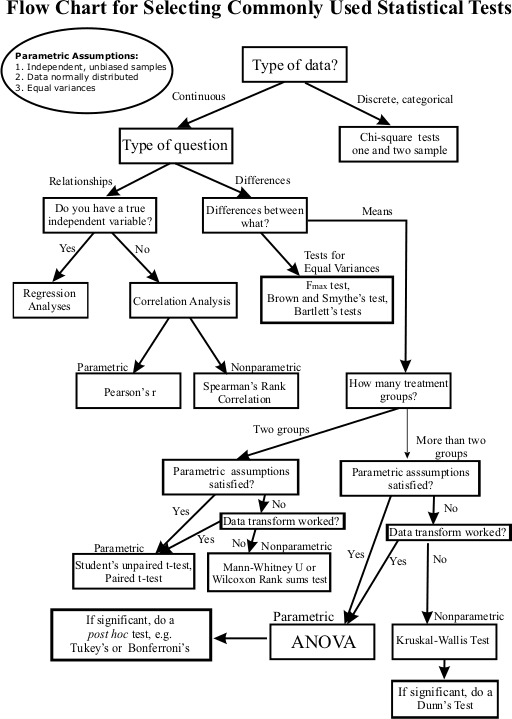

In [13]:
#сделаем себе парочку экспоненциальных распределений

gr_1 = rng.exponential(scale=1.0, size=1000)
gr_2 = rng.exponential(scale=1.1, size=1000)

<Axes: ylabel='Count'>

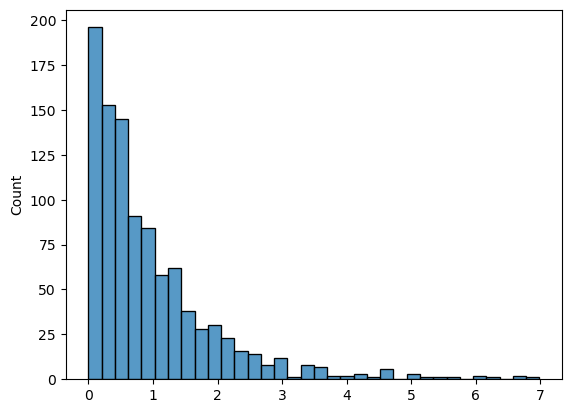

In [80]:
sns.histplot(gr_1)

<Axes: ylabel='Count'>

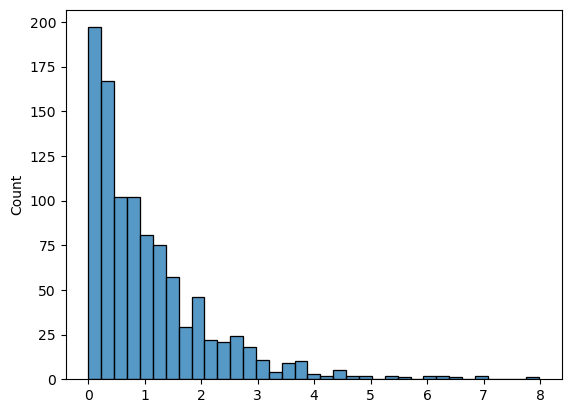

In [81]:
sns.histplot(gr_2)

In [82]:
print(f'''
Средние в двух группах: {gr_1.mean()} | {gr_2.mean()}
Медианы в двух группах: {np.median(gr_1)} | {np.median(gr_2)}
Усечённые средние в двух группах (20%): {st.trim_mean(gr_1, 0.2)} | {st.trim_mean(gr_2, 0.2)}
''')


Средние в двух группах: 0.9648093046136873 | 1.078932702380535
Медианы в двух группах: 0.6277213669674688 | 0.7424068340226766
Усечённые средние в двух группах (20%): 0.7109936517628974 | 0.813622921653095



In [84]:
st.ttest_ind(gr_1, gr_2, trim=0.2, equal_var=False) #t-тест усечённых средних

Ttest_indResult(statistic=-2.5273720487010096, pvalue=0.011622456935969121)

In [83]:
pg.ttest(gr_1, gr_2) #t-тест средних

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.405389,1998,two-sided,0.016246,"[-0.21, -0.02]",0.107572,0.885,0.671582


In [85]:
pg.compute_bootci(gr_1, gr_2, func=lambda x, y: np.median(x) - np.median(y)) #бутстрап медиан (перцентильный)

array([-0.21, -0.03])

In [86]:
st.median_test(gr_1, gr_2) #тест медиан Муда

MedianTestResult(statistic=6.498, pvalue=0.010799590882009212, median=0.6907249397303056, table=array([[471, 529],
       [529, 471]], dtype=int64))

In [87]:
pg.mwu(gr_1, gr_2) #манна-уитни

,U-val,alternative,p-val,RBC,CLES
MWU,468973.0,two-sided,0.016274,0.062054,0.468973


In [88]:
st.brunnermunzel(gr_1, gr_2) #бруннер-манцель

BrunnerMunzelResult(statistic=2.4059918786331678, pvalue=0.01621926163200449)

In [89]:
#сделаем из этого датафрейм

dat = pd.DataFrame({"group":np.repeat(["gr_1", "gr_2"], 1000),
                   "value":np.concatenate([gr_1, gr_2])})
dat.head()

,group,value
0,gr_1,2.811803
1,gr_1,0.005073
2,gr_1,0.085508
3,gr_1,0.182000
4,gr_1,1.167006


In [90]:
#обычная линейная регрессия
smf.ols("value ~ group", dat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.786
Date:                Tue, 25 Apr 2023   Prob (F-statistic):             0.0162
Time:                        23:18:37   Log-Likelihood:                -2955.1
No. Observations:                2000   AIC:                             5914.
Df Residuals:                    1998   BIC:                             5925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9648      0.034     28.759      0.000       0.899       1.031
group[T.gr_2]     0.1141      0.047      2.405      0.016       0.021       0.207
==============================================================================
Omnibus:                      916.710   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4900.080
Skew:                           2.148   Prob(JB):                         0.00
Kurtosis:                       9.352   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
#обобщённая линейная регрессия
smf.glm("value ~ group", dat, family = sm.families.Gamma(link=sm.families.links.identity())).fit().summary()

D:\Mambaforge\envs\mne\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  value   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1998
Model Family:                   Gamma   Df Model:                            1
Link Function:               identity   Scale:                          1.0795
Method:                          IRLS   Log-Likelihood:                -2042.9
Date:                Tue, 25 Apr 2023   Deviance:                       2334.5
Time:                        23:18:52   Pearson chi2:                 2.16e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002889
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9648      0.032     30.436      0.000       0.903       1.027
group[T.gr_2]     0.1141      0.048      2.400      0.016       0.021       0.207
=================================================================================
"""

D:\Mambaforge\envs\mne\lib\site-packages\pingouin\plotting.py:818: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax1 = sns.stripplot(
D:\Mambaforge\envs\mne\lib\site-packages\pingouin\plotting.py:869: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(["Y", "X"], size=15)


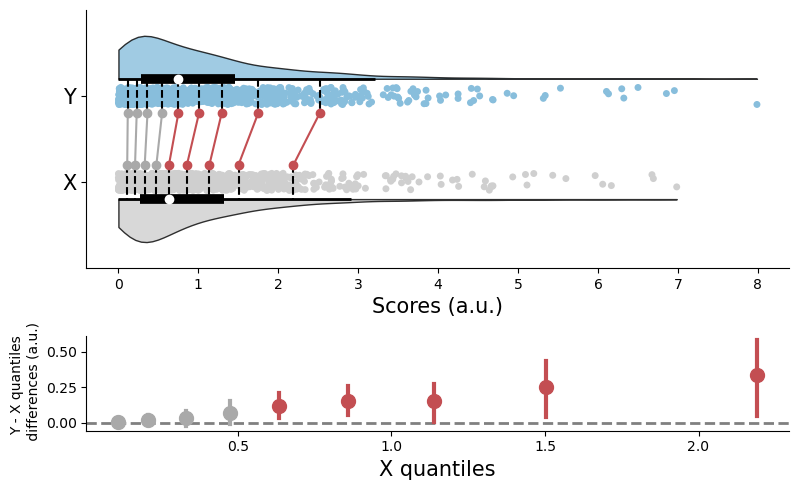

In [95]:
#децили

pg.plot_shift(gr_1, gr_2)
plt.show()

## Есть ли ограничения у бутстрапа? Как он работает?

Бутстрап - это группа методов, а не один метод. Основывается на идее взятия [подвыборок из выборки с повторением](https://seeing-theory.brown.edu/frequentist-inference/index.html).

Есть [несколько подходов](https://influentialpoints.com/Training/bootstrap_confidence_intervals-principles-properties-assumptions.htm) к тому, как его высчитывать.

Готовые решения в питоне: [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html), [pingouin](https://pingouin-stats.org/build/html/generated/pingouin.compute_bootci.html#pingouin.compute_bootci).

Главные подводные камни:

* Вычислительная нагрузка
* Нужны достаточно большие размеры выборок, чтобы работало нормально
* Не все статистики ведут себя с бутстрапом одинаково хорошо - часто надо корректировать смещение
* Зависимость наблюдений может быть критична

Бывают особо хитрые [версии бутстрапа](https://arch.readthedocs.io/en/latest/bootstrap/semiparametric-parametric-bootstrap.html#parametric-bootstraps) для регрессионных моделей.

In [96]:
#реальные различия 90%-ых децилей

np.quantile(gr_1, q = 0.9) - np.quantile(gr_2, q = 0.9)

-0.3358140144076236

In [97]:
#наивный перцентильный бутстрап
pg.compute_bootci(gr_1, gr_2, 
                  func = lambda x, y: np.quantile(x, q = 0.9) - np.quantile(y, q = 0.9), 
                  method = "per")

array([-0.58, -0.07])

In [98]:
#с поправкой на смещение
pg.compute_bootci(gr_1, gr_2, 
                  func = lambda x, y: np.quantile(x, q = 0.9) - np.quantile(y, q = 0.9), 
                  method = "cper")

array([-0.58, -0.06])

In [99]:
#с предположением о ЦПТ
pg.compute_bootci(gr_1, gr_2, 
                  func = lambda x, y: np.quantile(x, q = 0.9) - np.quantile(y, q = 0.9), 
                  method = "norm")

array([-0.63, -0.06])

In [100]:
#BCa

st.bootstrap((gr_1, gr_2), 
             statistic=lambda x, y: np.quantile(x, q = 0.9) - np.quantile(y, q = 0.9), 
             method="BCa")

BootstrapResult(confidence_interval=ConfidenceInterval(low=-0.5889570827134869, high=-0.06017451903986526), bootstrap_distribution=array([-0.34788649, -0.51391289, -0.51617131, ..., -0.20971089,
       -0.40594752, -0.10600215]), standard_error=0.1423826579475311)

In [101]:
#обратный

st.bootstrap((gr_1, gr_2), 
             statistic=lambda x, y: np.quantile(x, q = 0.9) - np.quantile(y, q = 0.9), 
             method="basic")

BootstrapResult(confidence_interval=ConfidenceInterval(low=-0.614653948051034, high=-0.09377081941890586), bootstrap_distribution=array([-0.18272693, -0.29890681, -0.45651831, ..., -0.31750463,
       -0.20661376, -0.44737   ]), standard_error=0.13971613528067744)

## Что делать с зависимыми выборками?

Для парных наблюдений существует отдельная категория методов (смотрим на примере [пингвина](https://pingouin-stats.org/build/html/api.html)). В индустрии встречается реже ввиду эффектов переноса - однако [switchback-тесты](https://medium.com/statistics-experiments/switchback-%D1%82%D0%B5%D1%81%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D0%BA%D0%B0%D0%BA-%D0%B1%D0%BE%D1%80%D0%BE%D1%82%D1%8C%D1%81%D1%8F-%D1%81-%D1%81%D0%BE%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%BC%D0%B8-%D1%8D%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B0%D0%BC%D0%B8-%D0%B2-a-b-%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%85-39aab4f87cf7) отчасти про это.

Отдельный мощный метод - [модели со смешанными эффектами](https://www.statsmodels.org/stable/mixed_linear.html) и похожие на них [GEE](https://www.statsmodels.org/stable/gee.html).

## Как считается размер выборки/как подбирается MDE?

MDE - обычно вопрос соглашения, какой самый мелкий эффект интересен заказчику.

Есть две хорошие статьи от expf: [раз](https://medium.com/statistics-experiments/%D0%BA%D0%BE%D0%B3%D0%B4%D0%B0-%D0%BE%D1%81%D1%82%D0%B0%D0%BD%D0%B0%D0%B2%D0%BB%D0%B8%D0%B2%D0%B0%D1%82%D1%8C-a-b-%D1%82%D0%B5%D1%81%D1%82-%D1%87%D0%B0%D1%81%D1%82%D1%8C-1-mde-7d39b668b488) и [два](https://medium.com/statistics-experiments/%D0%BA%D0%BE%D0%B3%D0%B4%D0%B0-%D0%BE%D1%81%D1%82%D0%B0%D0%BD%D0%B0%D0%B2%D0%BB%D0%B8%D0%B2%D0%B0%D1%82%D1%8C-a-b-%D1%82%D0%B5%D1%81%D1%82-%D1%87%D0%B0%D1%81%D1%82%D1%8C-2-monte-carlo-a342ba5b552c)

Некоторые готовые функции в пингвине: [тык](https://pingouin-stats.org/build/html/api.html#power-analysis)

Есть известный [калькулятор для конверсий](https://www.evanmiller.org/ab-testing/sample-size.html) от Evan Miller.

In [10]:
#немного демонстрации 
#допустим, мы увеличиваем средний чек
# наш MDE - 1000 рублей
# стандартное отклонение в чеках - 500 рублей

effsize = 10000 / 50000

pg.power_ttest(d=effsize, power=0.7, alpha=0.1)

235.9196927668734

In [69]:
#если есть исторические данные, то при желании можно считать MDE напрямую

pg.compute_effsize(gr_1, gr_2)

-0.21113123490978902

In [4]:
# можно указать размер выборки, и вернётся MDE

pg.power_ttest(n=100, power=0.8, alpha=0.05)

0.3981381375678977

In [11]:
np.arange(50, 1050, 50)

array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000])

In [107]:
#можно подойти к вопросу с помощью симуляций

mood_powers = [] # тест Муда и его мощности
boot_powers = [] # бутстрап медиан и его мощности

for sample_size in np.arange(50, 1050, 50): #для каждого размера выборки
    
    mood_pvals = [] #значимые p-value для теста Муда
    boot_pvals = [] #случаи пересечения нуля для бутстрапа медиан
    
    #проведём эксперимент несколько раз
    for _ in tqdm(range(1000)):
        
        #создаём две отличающиеся группы определённого размера
        power_1 = rng.exponential(scale=1.0, size=sample_size)
        power_2 = rng.exponential(scale=1.1, size=sample_size)
        
        #проводим наши тесты
        mood = st.median_test(power_1, power_2)
        boot = pg.compute_bootci(power_1, power_2, func = lambda x, y: np.median(x) - np.median(y))
        
        #сохраняем, прошёл ли проверку или нет
        mood_pvals.append(int(mood.pvalue < 0.05))
        boot_pvals.append(int(np.sign(boot)[0] == np.sign(boot)[1]))
        
    #считаем, сколько раз результат оказался значимым, и сохраняем
    mood_powers.append(sum(mood_pvals) / len(mood_pvals))
    boot_powers.append(sum(boot_pvals) / len(boot_pvals))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
samp_sizes = np.arange(50, 1050, 50)

In [113]:
#делаем датафрейм

power_df = pd.DataFrame({"sample_size":np.concatenate([samp_sizes, samp_sizes]),
                        "test":np.repeat(["Муд", "Бутстрап"], 20), 
                        "power":np.concatenate([mood_powers, boot_powers])})

<Axes: xlabel='sample_size', ylabel='power'>

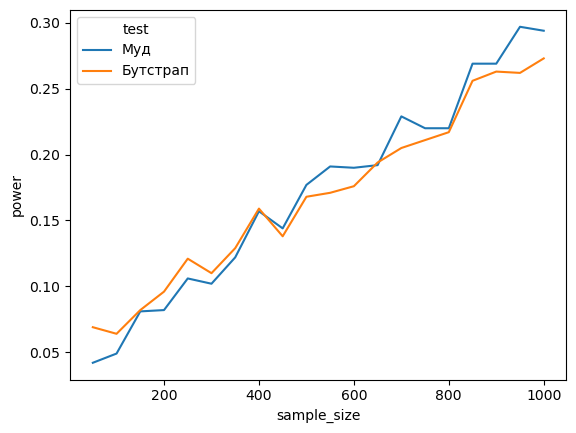

In [114]:
sns.lineplot(data=power_df, x="sample_size", y="power", hue="test")

In [115]:
# таким же образом можно проверить тенденцию теста ошибаться

mood_fpr = [] # тест Муда и его FPR
boot_fpr = [] # бутстрап медиан и его FPR

for sample_size in np.arange(50, 1050, 50): #для каждого размера выборки
    
    mood_pvals = [] #значимые p-value для теста Муда
    boot_pvals = [] #случаи пересечения нуля для бутстрапа медиан
    
    #проведём эксперимент несколько раз
    for _ in tqdm(range(1000)):
        
        #создаём две НЕотличающиеся группы определённого размера
        fpr_1 = rng.exponential(scale=1.0, size=sample_size)
        fpr_2 = rng.exponential(scale=1.0, size=sample_size)
        
        #проводим наши тесты
        mood = st.median_test(fpr_1, fpr_2)
        boot = pg.compute_bootci(fpr_1, fpr_2, func = lambda x, y: np.median(x) - np.median(y))
        
        #сохраняем, есть ли ложное срабатывание или нет
        mood_pvals.append(int(mood.pvalue < 0.05))
        boot_pvals.append(int(np.sign(boot)[0] == np.sign(boot)[1]))
        
    #считаем, сколько раз результат оказался значимым, и сохраняем
    mood_fpr.append(sum(mood_pvals) / len(mood_pvals))
    boot_fpr.append(sum(boot_pvals) / len(boot_pvals))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='sample_size', ylabel='fpr'>

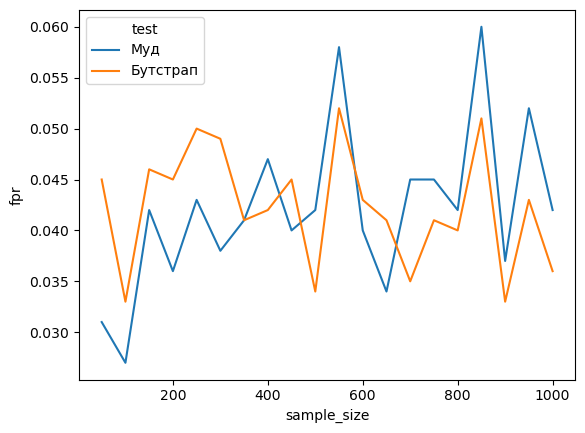

In [117]:
#делаем датафрейм

fpr_df = pd.DataFrame({"sample_size":np.concatenate([samp_sizes, samp_sizes]),
                        "test":np.repeat(["Муд", "Бутстрап"], 20), 
                        "fpr":np.concatenate([mood_fpr, boot_fpr])})

sns.lineplot(data=fpr_df, x="sample_size", y="fpr", hue="test")

Почему бы не сделать то же самое для t-теста (классического и на усечённых средних) и бутстрапа средних?

In [3]:
mean_powers = [] # классический ттест и его мощности
trim_powers = [] # усеченный ттест и его мощности
boot_mean_powers = [] # бутстрап средних и его мощности

for sample_size in np.arange(50, 1050, 50): #для каждого размера выборки
    
    mean_pvals = [] #значимые p-value для классического ттеста
    trim_pvals = [] #значимые p-value для ттеста на усечённых средних
    boot_mean_pvals = [] #случаи пересечения нуля для бутстрапа средних
    
    #проведём эксперимент несколько раз
    for _ in tqdm(range(1000)):
        
        #создаём две отличающиеся группы определённого размера
        power_1 = rng.exponential(scale=1.0, size=sample_size)
        power_2 = rng.exponential(scale=1.1, size=sample_size)
        
        #проводим наши тесты
        ttest = st.ttest_ind(power_1, power_2, equal_var=False)
        trim = st.ttest_ind(power_1, power_2, trim=0.2, equal_var=False)
        boot = pg.compute_bootci(power_1, power_2, func = lambda x, y: np.mean(x) - np.mean(y))
        
        
        #сохраняем, прошёл ли проверку или нет
        mean_pvals.append(int(ttest.pvalue < 0.05))
        trim_pvals.append(int(trim.pvalue < 0.05))
        boot_mean_pvals.append(int(np.sign(boot)[0] == np.sign(boot)[1]))
        
    #считаем, сколько раз результат оказался значимым, и сохраняем
    mean_powers.append(sum(mean_pvals) / len(mean_pvals))
    trim_powers.append(sum(trim_pvals) / len(trim_pvals))
    boot_mean_powers.append(sum(boot_mean_pvals) / len(boot_mean_pvals))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='sample_size', ylabel='power'>

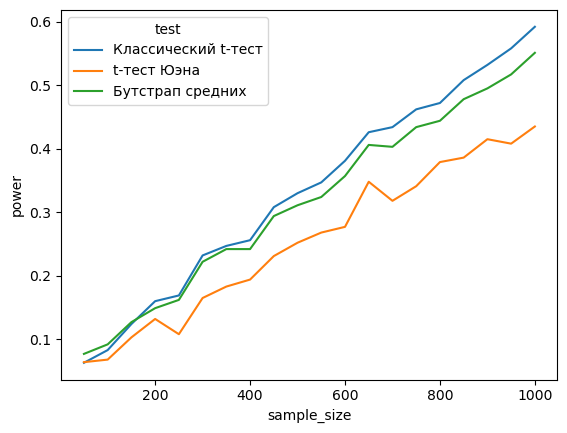

In [6]:
#делаем датафрейм

power_df = pd.DataFrame({"sample_size":np.concatenate([samp_sizes, samp_sizes, samp_sizes]),
                        "test":np.repeat(["Классический t-тест", "t-тест Юэна","Бутстрап средних"], 20), 
                        "power":np.concatenate([mean_powers, trim_powers, boot_mean_powers])})

sns.lineplot(data=power_df, x="sample_size", y="power", hue="test")

In [7]:
mean_fpr = [] # классический ттест и его FPR
trim_fpr = [] # усеченный ттест и его FPR
boot_mean_fpr = [] # бутстрап средних и его FPR

for sample_size in np.arange(50, 1050, 50): #для каждого размера выборки
    
    mean_pvals = [] #значимые p-value для классического ттеста
    trim_powers = [] #значимые p-value для ттеста на усечённых средних
    boot_mean_pvals = [] #случаи пересечения нуля для бутстрапа средних
    
    #проведём эксперимент несколько раз
    for _ in tqdm(range(1000)):
        
        #создаём две НЕотличающиеся группы определённого размера
        fpr_1 = rng.exponential(scale=1.0, size=sample_size)
        fpr_2 = rng.exponential(scale=1.0, size=sample_size)
        
        #проводим наши тесты
        ttest = st.ttest_ind(fpr_1, fpr_2, equal_var=False)
        trim = st.ttest_ind(fpr_1, fpr_2, trim=0.2, equal_var=False)
        boot = pg.compute_bootci(fpr_1, fpr_2, func = lambda x, y: np.mean(x) - np.mean(y))
        
        
        #сохраняем, есть ли ложноположительное срабатывание
        mean_pvals.append(int(ttest.pvalue < 0.05))
        trim_pvals.append(int(trim.pvalue < 0.05))
        boot_mean_pvals.append(int(np.sign(boot)[0] == np.sign(boot)[1]))
        
    #считаем, сколько раз результат оказался значимым, и сохраняем
    mean_fpr.append(sum(mean_pvals) / len(mean_pvals))
    trim_fpr.append(sum(trim_pvals) / len(trim_pvals))
    boot_mean_fpr.append(sum(boot_mean_pvals) / len(boot_mean_pvals))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='sample_size', ylabel='fpr'>

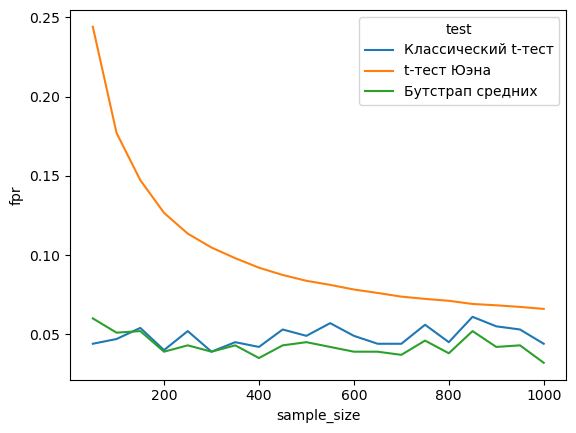

In [9]:
fpr_df = pd.DataFrame({"sample_size":np.concatenate([samp_sizes, samp_sizes, samp_sizes]),
                        "test":np.repeat(["Классический t-тест", "t-тест Юэна","Бутстрап средних"], 20), 
                        "fpr":np.concatenate([mean_fpr, trim_fpr, boot_mean_fpr])})

sns.lineplot(data=fpr_df, x="sample_size", y="fpr", hue="test")

## Организация экспериментов и A/A/B

А/А/B-тесты существуют! Но важно учитывать тот факт, что если по истечении периода А/А-часть не сойдётся, то эксперимент невалиден, и придётся всё проводить заново.

Про организацию экспериментов именно в бизнесе лучше всего читать книжку [Доверительное АБ-тестирование](https://dmkpress.com/catalog/computer/software_development/978-5-97060-913-2/).

## Насколько корректно преобразовывать полученные данные?

It depends (c)